In [1]:
#!/usr/bin/env python
# coding: utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torchtext
from torchtext import data, datasets
from torchtext.vocab import FastText

import os
import math
import MeCab
import shutil

device="cuda:0" if torch.cuda.is_available() else "cpu"
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
mecab = MeCab.Tagger("-Owakati")

# BLEU

from Util.selfbleu import CalcSelfBLEU
from Util.bleu import calc_all_bleu

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import torchwordemb
w2v, vec = torchwordemb.load_word2vec_text('./data/vector/model.vec')

In [3]:
# HYPER PARAMETER
BATCH_SIZE=128
EMBED_SIZE=300
LSTM_HIDDEN_SIZE=500
KL_START_EPOCH=15
AE_EPOCHS=100
REPORT_INTERVAL=5
ae_lr=1e-2

In [4]:
# LABEL NAME
data_source="twitter"
feature="QplusA"
# feature="only_ja_sample"
# data_source="orphans"
# feature="all"

log_dir='./log/{}/'.format("_".join(["train",data_source,feature]))
# if os.path.isdir(log_dir):
#     shutil.rmtree(log_dir)
# os.mkdir(log_dir)

In [5]:
model_path={}
model_path["AE"]=log_dir+"_".join(["AE",data_source,feature])
model_path["FNN"]=log_dir+"_".join(["FNN",data_source,feature])

In [6]:
if data_source=="wiki" or data_source=="orphans":
    MAX_LEN=20 #paddingをバッチにかかわらず固定長にする
    TEXT = data.Field(sequential=True, lower=True, include_lengths=True, init_token="<SOS>",eos_token="<EOS>", fix_length=MAX_LEN, batch_first=True)
    train, val, test = data.TabularDataset.splits(
        path='./data/foruse', train="_".join(["train",data_source,feature])+'.tsv',
        validation="_".join(["eval",data_source,feature])+'.tsv',test="_".join(["test",data_source,feature])+'.tsv', 
        format='tsv',
        fields=[('Text', TEXT),])
#     TEXT.build_vocab(train, vectors=FastText(language="ja"))
    TEXT.build_vocab(train)
    TEXT.vocab.set_vectors(stoi=w2v, vectors=vec, dim=300)
    train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),sort = False, device=torch.device(device))
    vocab_size=TEXT.vocab.vectors.size()[0]

elif data_source=="twitter":
    MAX_LEN=20 #paddingをバッチにかかわらず固定長にする
    TEXT = data.Field(sequential=True, lower=True, include_lengths=True, init_token="<SOS>",eos_token="<EOS>", fix_length=MAX_LEN, batch_first=True)
    train, val, test = data.TabularDataset.splits(
        path='./data/foruse', train="_".join(["train",data_source,feature])+'.tsv',
        validation="_".join(["eval",data_source,feature])+'.tsv',test="_".join(["test",data_source,feature])+'.tsv', 
        format='tsv',
        fields=[('Text', TEXT),])
#     TEXT.build_vocab(train, vectors=FastText(language="ja"))
    TEXT.build_vocab(train,val)
    TEXT.vocab.set_vectors(stoi=w2v, vectors=vec, dim=300)
    train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),sort = False, device=torch.device(device))
    vocab_size=TEXT.vocab.vectors.size()[0]

In [7]:
vocab_size

29858

In [8]:
share_conv=nn.Embedding(vocab_size, EMBED_SIZE).to(device)
share_conv.weight.data.copy_(TEXT.vocab.vectors)
share_conv.weight.requires_grad = False

In [9]:
class Encoder(nn.Module):
    def __init__(self,embed_size,n_hid):
        super().__init__()
        self.lstm = nn.LSTM(input_size = embed_size,
                            hidden_size = n_hid,
                            batch_first=True)
        
    def forward(self, x):
        """
        input: 
            x = (batch, max_len, embed_dim)
        output:
            x = (batch, hidden_size)
        """
        _, (h,c)=self.lstm(x) # h=(max_len, batch, n_hid)
        return (h,c)

In [10]:
class vae_classifier_2layer(nn.Module):
    def __init__(self,n_hid):
        super().__init__()
        self.fc = nn.Linear(n_hid*2, n_hid)
        self.fcmean = nn.Linear(n_hid, n_hid)
        self.fcvar = nn.Linear(n_hid, n_hid)
        self.ReLU=nn.ReLU()
        self.lnorm=nn.LayerNorm(n_hid)

    def forward(self, hidden):# h,c = (batch, hidden_size)
        h, c = hidden
        tmp = self.ReLU(self.lnorm(self.fc(torch.cat([h,c],dim=-1))))
        mean = self.fcmean(tmp)
        log_sigma_sq = self.fcvar(tmp)
        return mean, log_sigma_sq


In [11]:
class Decoder(nn.Module):
    def __init__(self,embed_size,n_hid,max_len,vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size = embed_size,
                            hidden_size = n_hid,
                            batch_first=True)
        self.fc = nn.Linear(n_hid, vocab_size)
        self.embed_size=embed_size
        self.max_len=max_len
        self.n_hid=n_hid
        self.embedding=share_conv
        self.fc1 = nn.Linear(self.n_hid, self.n_hid)
        self.fc2 = nn.Linear(self.n_hid, self.n_hid)
        
    def forward(self, hidden, x, teacher):
        """
        input:
            x_emb=(batch, hidden_size, embedding_size)
        output:
            logits = (batch, max_len, vocab_size)
            sentence = (batch, max_len) : 中身はindex
        """
        logits = torch.tensor([]).to(device)
        sentence = torch.tensor([],dtype=torch.long).to(device)
        hidden=(self.fc1(hidden), self.fc2(hidden))
        for i in range(self.max_len):
            if torch.rand(1)<1/3:
                # word dropout
                tmp=torch.zeros(len(x), 1, self.embed_size).to(device)
            elif teacher or i==0:
                tmp = torch.unsqueeze(x[:,i,:],1) # tmp = (batch, 1, embed_dim)
            else:
                # word = (batch, 1, 1)
                tmp = self.embedding(word) # tmp = (batch, 1, embed_dim)
                tmp = F.normalize(tmp)
            x_input = tmp # x_input = (batch, 1, (embed_size + n_hid))
            out, hidden = self.lstm(x_input, hidden)
                # out = (batch, 1, n_hid)
                # hidden = ((batch, 1, n_hid),(batch, 1, n_hid))
            logit = self.fc(out) # logit = (batch, 1, vocab_size)
            word = torch.argmax(logit, dim=2) # word = (batch, 1)

            sentence = torch.cat([sentence, word],1)
            logits = torch.cat([logits,logit],1)   
        return logits, sentence

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self,maxlen):
        super().__init__()
        self.n_hid=LSTM_HIDDEN_SIZE
        self.maxlen=maxlen
        self.encoder=Encoder(embed_size=EMBED_SIZE,n_hid=self.n_hid)
        self.vae_classifer=vae_classifier_2layer(n_hid=self.n_hid)
        self.decoder=Decoder(embed_size=EMBED_SIZE,n_hid=self.n_hid,max_len=MAX_LEN,vocab_size=vocab_size)
        self.embedding=share_conv
        
    def forward(self, x): # x=(batch, max_len)
        x_emb=self.embedding(x)  # x_emb = (batch, maxlen, embed_dim)
        x_emb = F.normalize(x_emb)
        
        hidden = self.encoder(x_emb) # h,c = (1, batch, hidden_size)
        mean, log_sigma_sq=self.vae_classifer(hidden)
        eps = torch.empty(len(x), self.n_hid).normal_(mean=0,std=1).to(device) # N(0, 1)
        out_h = mean + eps * torch.sqrt(torch.exp(log_sigma_sq)) # H_dec = (1, batch, n_gan)
        logits, sentence = self.decoder(out_h, x_emb, teacher=True)
        
        # loss
        criterion = nn.CrossEntropyLoss(ignore_index=1)
        loss = 0
        for i in range(self.maxlen-1):
            # <SOS>を除くためindexをずらす
            loss += criterion(torch.squeeze(logits[:,i,:]), torch.squeeze(x[:,i+1]))
        loss/=(self.maxlen-1)
        
        # KL loss
        # 標準正規分布と(μ,σ^2)正規分布を仮定しているので以下の計算式になる
        # nn.klDivLossを使うと仮定が甘い
        # kl_loss = Σ0.5Σ(μ^2+exp(ln(σ^2))-ln(σ^2)-1)を使う
        kl_loss = torch.sum(0.5 * torch.sum((mean**2 + torch.exp(log_sigma_sq) - log_sigma_sq - 1),dim=1))
        if epoch>KL_START_EPOCH:
            loss += (epoch-KL_START_EPOCH)/(AE_EPOCHS-KL_START_EPOCH)*kl_loss
        
        return loss, sentence, out_h


In [13]:
def change_to_sent(sents,j):
    word_list=[]
    for i in sents[j]:
        if i==TEXT.vocab.stoi["<EOS>"]:
            break
        if i!=TEXT.vocab.stoi["<PAD>"]:
            word_list.append(TEXT.vocab.itos[int(i)])
    return word_list

def write_out(url, origin_sents, syn_sents):
    with open(url, "w") as f:
        for j in range(len(syn_sents)):
            f.write("input : "+" ".join(change_to_sent(origin_sents,j))+"\n")
            f.write("output: "+" ".join(change_to_sent(syn_sents,j))+"\n\n")

In [14]:
def train():
    auto_encoder.train()
    epoch_loss = 0
    count=0
    for idx, batch in enumerate(train_iter):
        (x, x_l) = batch.Text
            # xには文章のID表現が、x_lにはxの単語数が入る
            # x=(batch, max_len)
#         if len(x)!=BATCH_SIZE:break
        optimizer.zero_grad()
        loss, syn_sents, _=auto_encoder(x)        
        with torch.autograd.detect_anomaly():
            loss.backward()
            optimizer.step()
        epoch_loss+=loss.item()
        count+=1
        
    sample_x=x[0][1:]
    source_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in sample_x if i != 1])
    gen_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in syn_sents[0] if i != 1])

    write_out(log_dir+"AE_train{:03}.txt".format(epoch), x[:,1:], syn_sents)

    history_train.append(epoch_loss/count)
    if (epoch+1) % REPORT_INTERVAL==0:
        print("epoch: "+str(epoch+1)+'/'+str(AE_EPOCHS)+' ')
        print("training loss: "+str(history_train[epoch]))
#         print("kl_loss: "+str(kl_loss))
        print("source(train): "+str(source_sentence))
        print("result(train): "+str(gen_sentence))


In [15]:
def val():
    auto_encoder.eval()
    epoch_loss = 0
    count=0
    for idx, batch in enumerate(val_iter):
        (x, x_l) = batch.Text
            # xには文章のID表現が、x_lにはxの単語数が入る
            # x=(batch, max_len)
        loss, syn_sents, _=auto_encoder(x)        
        epoch_loss+=loss.item()
        count+=1
        
    sample_x=x[0][1:]
    source_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in sample_x if i != 1])
    gen_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in syn_sents[0] if i != 1])

    write_out(log_dir+"AE_val{:03}.txt".format(epoch), x[:,1:], syn_sents)

    history_val.append(epoch_loss/count)
    if (epoch+1) % REPORT_INTERVAL==0:
        print("epoch: "+str(epoch+1)+'/'+str(AE_EPOCHS)+' ')
        print("training loss: "+str(history_train[epoch]))
#         print("kl_loss: "+str(kl_loss))
        print("source(train): "+str(source_sentence))
        print("result(train): "+str(gen_sentence))

In [16]:
'''
学習を始める
'''
print("start train...")
auto_encoder=AutoEncoder(maxlen=MAX_LEN)
auto_encoder.to(device)
optimizer = optim.Adam(auto_encoder.parameters(), lr=ae_lr)
history_train=[]
history_val=[]

for epoch in range(AE_EPOCHS):
    train()
    val()
torch.save(auto_encoder.state_dict(), model_path["AE"])

start train...
epoch: 5/100 
training loss: 4.707981797575041
source(train): それ も 分から ん けどなんで よ 子供 だ よ <EOS>
result(train): いや は いい ん だ よ な な よ <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch: 5/100 
training loss: 4.707981797575041
source(train): それ な 思っ た わトゥンク とか どう でも いい です から ねぇ <EOS>
result(train): いや は に た ん だ 言わ し いい よ か ね <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch: 10/100 
training loss: 4.047190997436757
source(train): マジマジ わん ちゃん 中学生 かも しれ ない て か タメ で いい のにでも 初対面 の 人 に やら <EOS>
result(train): それ の の に の しれ ない 宮野いい の よ で いい ん だ だ 方 に <EOS> <EOS> <EOS>
epoch: 10/100 
training loss: 4.047190997436757
source(train): それ な 思っ た わトゥンク とか どう でも いい です から ねぇ <EOS>
result(train): それ の ん た けど です な し いい か よ <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch: 15/100 
training loss: 3.6954896622941695
source(train): めっちゃ たる さん と 笑っ て まし ためっちゃ 面白かっ た です ね じいちゃん <EOS>
result(train): それ 笑っ ん は 言っ ござい まし まし ござい た ん か びっくり 笑 <EOS> <EOS> <EOS> <EOS> <E

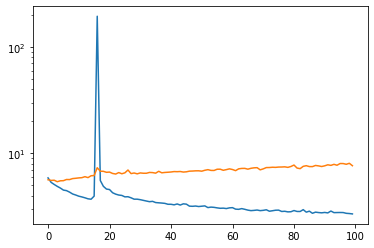

In [17]:
x = [i for i in range(len(history_train))]
fig, ax = plt.subplots()
ax.plot(x, history_train)
ax.plot(x, history_val)
ax.set_yscale('log')
# plt.legend()
plt.show()

In [42]:
from Util.bert_score.bert_score.score import score

def calc_bert_score(cands, refs):
    """ BERTスコアの算出

    Args:
        cands ([List[str]]): [比較元の文]
        refs ([List[str]]): [比較対象の文]

    Returns:
        [(List[float], List[float], List[float])]: [(Precision, Recall, F1スコア)]
    """
    Precision, Recall, F1 = score(cands, refs, lang="ja", verbose=True)
    return Precision.numpy().tolist(), Recall.numpy().tolist(), F1.numpy().tolist()
def AE_bert_score(_type):
    p_history,r_history,f1_history=[],[],[]
    """ サンプル実行 """ 
    for i in range(AE_EPOCHS):
        filename=log_dir+"AE_{}{:03}.txt".format(_type,i)
        with open(filename) as f:
            cands = ["".join(line.strip().split()[1:]) for idx, line in enumerate(f) if idx%3==0]
        with open(filename) as f:
            refs = ["".join(line.strip().split()[1:]) for idx, line in enumerate(f) if idx%3==1]
        P, R, F1 = calc_bert_score(cands, refs)
        p_history.append(sum(P)/len(P))
        r_history.append(sum(R)/len(R))
        f1_history.append(sum(F1)/len(F1))
    return p_history

vae_bert_train=AE_bert_score("train")
vae_bert_val=AE_bert_score("val")

calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 405.90 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 411.37 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 389.22 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 399.73 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 385.60 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 377.90 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 405.16 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 425.78 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 385.37 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 394.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 383.81 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.35 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 392.59 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 393.10 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 400.02 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 362.51 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 393.14 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.36 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 406.75 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.29 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 389.41 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.90 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 404.02 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 354.72 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 369.85 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 410.89 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 405.54 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 387.35 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 389.67 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 393.78 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 411.91 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 391.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 386.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 363.22 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 403.14 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 411.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 388.59 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 408.54 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 389.65 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.15 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 408.97 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 395.02 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 382.27 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 406.78 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 376.60 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 410.03 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 402.19 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 377.72 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.07 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 379.77 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 381.22 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 387.52 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 390.95 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 366.51 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 412.18 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 385.56 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.42 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 384.46 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 380.40 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 395.79 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 404.88 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 408.24 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 411.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 356.77 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 392.64 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 400.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 370.75 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 368.55 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 365.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.21 seconds, 336.63 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 384.44 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.50 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 375.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 407.63 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.21 seconds, 339.77 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 410.24 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 379.01 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 399.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 383.91 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 356.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.21 seconds, 347.74 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 385.54 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 390.64 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 401.93 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 395.29 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 411.97 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 408.12 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 401.86 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 381.13 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 378.80 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 399.25 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 412.52 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 390.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 411.47 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 379.07 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 394.64 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.96 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 381.67 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 400.91 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 358.69 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.10 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.64 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.92 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.58 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.92 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 305.95 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 308.78 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.63 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.37 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 358.65 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.81 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.81 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.33 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.48 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.86 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.58 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.86 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.53 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.29 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 357.99 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 328.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.96 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.44 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 348.29 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 361.46 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.56 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 357.69 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.28 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 357.48 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.58 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.11 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.83 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.39 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 356.20 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 346.13 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.37 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.18 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 358.92 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.61 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 356.37 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.79 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 342.16 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.40 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 356.01 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 307.11 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.10 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.65 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.27 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.01 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.16 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.47 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.20 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 339.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 356.74 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.11 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.61 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.02 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.71 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 308.81 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.14 seconds, 302.20 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 304.36 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 311.13 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.27 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.25 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.08 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.22 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 347.77 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.67 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 348.40 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.49 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.59 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 345.16 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 346.22 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.33 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.05 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 348.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.18 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.57 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 339.91 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.71 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 344.11 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.36 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.80 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 356.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.77 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 339.91 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 356.25 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.98 sentences/sec


In [43]:
from Util.selfbleu import CalcSelfBLEU
def vae_selfbleu(_type):
    selfbleu_history=[]
    for i in range(AE_EPOCHS):
        filename=log_dir+"AE_{}{:03}.txt".format(_type,i)
        selfbleu2=CalcSelfBLEU(filename)
        selfbleu_history.append(selfbleu2)
    return selfbleu_history
vae_selfbleu_train=vae_selfbleu("train")
vae_selfbleu_val=vae_selfbleu("val")

Self-BLEU(2-gram)：0.4235929873157105
Self-BLEU(3-gram)：0.27106249913839436
Self-BLEU(4-gram)：0.1689312213840918
Self-BLEU(2-gram)：0.4063633003006823
Self-BLEU(3-gram)：0.25686443649603835
Self-BLEU(4-gram)：0.1464103578257408
Self-BLEU(2-gram)：0.4154313346625016
Self-BLEU(3-gram)：0.2882096856378448
Self-BLEU(4-gram)：0.23312077835567754
Self-BLEU(2-gram)：0.40976805040217845
Self-BLEU(3-gram)：0.2631474580229195
Self-BLEU(4-gram)：0.1669375780607034
Self-BLEU(2-gram)：0.36889810261859307
Self-BLEU(3-gram)：0.17259748817381715
Self-BLEU(4-gram)：0.030613298926706965
Self-BLEU(2-gram)：0.3840959347282895
Self-BLEU(3-gram)：0.23317809102898937
Self-BLEU(4-gram)：0.1326499612471413
Self-BLEU(2-gram)：0.3628558603317991
Self-BLEU(3-gram)：0.18660460381488975
Self-BLEU(4-gram)：0.0960862258667486
Self-BLEU(2-gram)：0.3590589897970401
Self-BLEU(3-gram)：0.15444906346712164
Self-BLEU(4-gram)：0.02250449950662537
Self-BLEU(2-gram)：0.3632793541279736
Self-BLEU(3-gram)：0.15542598626416226
Self-BLEU(4-gram)：0.02691

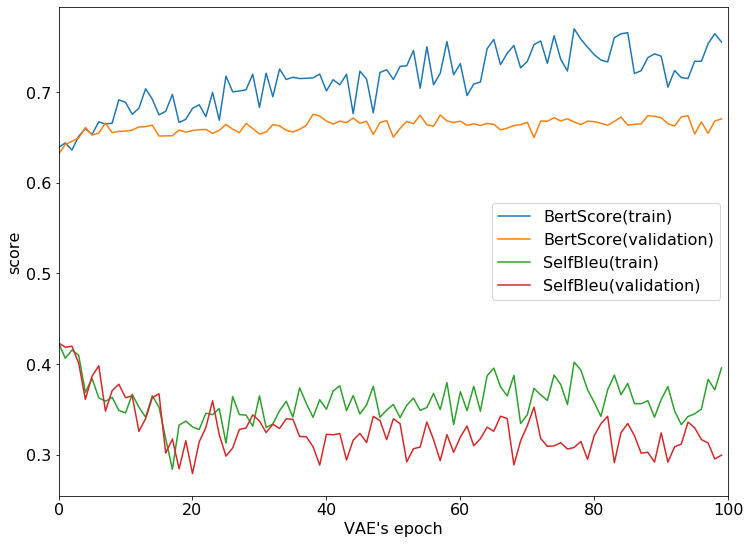

In [44]:
x = [i for i in range(len(vae_bert_train))]
fig = plt.figure(figsize=(12.0, 9.0))

plt.plot(x, vae_bert_train, label="BertScore(train)")
plt.plot(x, vae_bert_val, label="BertScore(validation)")
plt.plot(x, vae_selfbleu_train, label="SelfBleu(train)")
plt.plot(x, vae_selfbleu_val, label="SelfBleu(validation)")
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
plt.rcParams["font.size"] = 16

# fig, ax = plt.subplots()
plt.xlim(0, 100)
plt.xlabel("VAE's epoch")
plt.ylabel('score')
plt.legend()
plt.show()

## FNN

In [21]:
if data_source=="twitter":
    MAX_LEN=20 #paddingをバッチにかかわらず固定長にする
    QUESTION = data.Field(sequential=True, lower=True, include_lengths=True, init_token="<SOS>",eos_token="<EOS>", fix_length=MAX_LEN, batch_first=True)
    ANSWER = data.Field(sequential=True, lower=True, include_lengths=True, init_token="<SOS>",eos_token="<EOS>", fix_length=MAX_LEN, batch_first=True)
    train, val, test = data.TabularDataset.splits(
        path='./data/foruse', train="_".join(["train",data_source,"QandA"])+'.tsv',
        validation="_".join(["eval",data_source,"QandA"])+'.tsv',test="_".join(["test",data_source,feature])+'.tsv', 
        format='tsv',
        fields=[('Question', QUESTION),('Answer', ANSWER)])
    QUESTION.build_vocab(train,val)
    ANSWER.build_vocab(train,val)
    QUESTION.vocab=TEXT.vocab
    ANSWER.vocab=TEXT.vocab
    train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),sort = False, device=torch.device(device))

In [22]:
class FNN(nn.Module):
    def __init__(self,max_len,embed_size,n_hid):
        super().__init__()
        self.n_hid=n_hid
        self.max_len=max_len
        self.embed_size=embed_size
        self.embedding=share_conv
        self.lstm = auto_encoder.decoder.lstm
        self.fc = auto_encoder.decoder.fc
        self.fc1=auto_encoder.decoder.fc1
        self.fc2=auto_encoder.decoder.fc2
        self.fnn=nn.Linear(n_hid,n_hid)
    def forward(self, x_h, y_h):
        """
        input:
            x_emb=(batch, hidden_size, embedding_size)
        output:
            logits = (batch, max_len, vocab_size)
            sentence = (batch, max_len) : 中身はindex
        """
        logits = torch.tensor([]).to(device)
        sentence = torch.tensor([],dtype=torch.long).to(device)
        # loss
        criterion = nn.MSELoss()
        x_h=self.fnn(x_h)
        loss = criterion(torch.squeeze(x_h), torch.squeeze(y_h))
#         x_h,y_h=torch.unsqueeze(torch.squeeze(x_h),1),torch.unsqueeze(torch.squeeze(y_h),1)
        hidden=(self.fc1(x_h), self.fc2(x_h))
        for i in range(self.max_len):
            if i==0:
                tmp=torch.zeros(x_h.size()[1],1,self.embed_size).to(device)
            else:
                # word = (batch, 1, 1)
                tmp = self.embedding(word) # tmp = (batch, 1, embed_dim)
                tmp = F.normalize(tmp)
            x_input = tmp # x_input = (batch, 1, (embed_size + n_hid))
            out, hidden = self.lstm(x_input, hidden)
                # out = (batch, 1, n_hid)
                # hidden = ((batch, 1, n_hid),(batch, 1, n_hid))
            logit = self.fc(out) # logit = (batch, 1, vocab_size)
            word = torch.argmax(logit, dim=2) # word = (batch, 1)
            sentence = torch.cat([sentence, word],1) 
        return loss, sentence

In [23]:
def write_out(url, origin_sents, answer_sents, syn_sents):
    with open(url, "w") as f:
        for j in range(len(syn_sents)):
            f.write("input : "+" ".join(change_to_sent(origin_sents,j))+"\n")
            f.write("answer: "+" ".join(change_to_sent(answer_sents,j))+"\n")
            f.write("output: "+" ".join(change_to_sent(syn_sents,j))+"\n\n")

In [24]:
def fnn_train():
    epoch_loss = 0
    count=0
    for idx, batch in enumerate(train_iter):
        # 質問と回答で分ける
        (x, x_l),(y,y_l) = batch.Question, batch.Answer
            # xには文章のID表現が、x_lにはxの単語数が入る
            # x=(batch, max_len)
#         if len(x)!=BATCH_SIZE:break
        optimizer.zero_grad()
        _, _, x_h=auto_encoder(x)
        _, _, y_h=auto_encoder(y)
        loss,syn_sents=fnn(x_h,y_h)
        with torch.autograd.detect_anomaly():
            loss.backward()
            optimizer.step()
        epoch_loss+=loss.item()
        count+=1
        
    sample_x=x[0][1:]
    sample_y=y[0][1:]
    source_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in sample_x if i != 1])
    answer_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in sample_y if i != 1])
    gen_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in syn_sents[0] if i != 1])

    write_out(log_dir+"FNN_train{:03}.txt".format(epoch), x[:,1:],y[:,1:], syn_sents)

    history_train.append(epoch_loss/count)
    if (epoch+1) % REPORT_INTERVAL==0:
        print("epoch: "+str(epoch+1)+'/'+str(AE_EPOCHS)+' ')
        print("training loss: "+str(history_train[epoch]))
#         print("kl_loss: "+str(kl_loss))
        print("source(train): "+str(source_sentence))
        print("answer(train): "+str(answer_sentence))
        print("result(train): "+str(gen_sentence))


In [25]:
def fnn_val():
    epoch_loss = 0
    count=0
    for idx, batch in enumerate(val_iter):
        # 質問と回答で分ける
        (x, x_l),(y,y_l) = batch.Question, batch.Answer
            # xには文章のID表現が、x_lにはxの単語数が入る
            # x=(batch, max_len)
#         if len(x)!=BATCH_SIZE:break
        _, _, x_h=auto_encoder(x)
        _, _, y_h=auto_encoder(y)
        loss,syn_sents=fnn(x_h,y_h)
        epoch_loss+=loss.item()
        count+=1
        
    sample_x=x[0][1:]
    sample_y=y[0][1:]
    source_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in sample_x if i != 1])
    answer_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in sample_y if i != 1])
    gen_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in syn_sents[0] if i != 1])

    write_out(log_dir+"FNN_val{:03}.txt".format(epoch), x[:,1:],y[:,1:], syn_sents)

    history_val.append(epoch_loss/count)
    if (epoch+1) % REPORT_INTERVAL==0:
        print("epoch: "+str(epoch+1)+'/'+str(AE_EPOCHS)+' ')
        print("training loss: "+str(history_train[epoch]))
#         print("kl_loss: "+str(kl_loss))
        print("source(train): "+str(source_sentence))
        print("answer(train): "+str(answer_sentence))
        print("result(train): "+str(gen_sentence))


In [26]:
'''
学習を始める
'''
print("start train...")
for i in auto_encoder.parameters():
    i.requires_grad=False
fnn=FNN(MAX_LEN,EMBED_SIZE,LSTM_HIDDEN_SIZE)
fnn.to(device)
optimizer = optim.Adam(auto_encoder.parameters(), lr=ae_lr)
history_train=[]
history_val=[]

for epoch in range(AE_EPOCHS):
    fnn_train()
    fnn_val()
torch.save(auto_encoder.state_dict(), model_path["FNN"])

start train...
epoch: 5/100 
training loss: 1.3334022719441478
source(train): それ も 分から ん けど <EOS>
answer(train): なんで よ 子供 だ よ <EOS>
result(train): それ は は は は は は は は は は は は は は は は は は は
epoch: 5/100 
training loss: 1.3334022719441478
source(train): それ な 思っ た わ <EOS>
answer(train): トゥンク とか どう でも いい です から ねぇ <EOS>
result(train): それ は は は は は は は は は は は は は は は は は は は
epoch: 10/100 
training loss: 1.3334426611434413
source(train): マジマジ わん ちゃん 中学生 かも しれ ない て か タメ で いい のに <EOS>
answer(train): でも 初対面 の 人 に やら れる の ウザイ く ない <EOS>
result(train): それ は は は は は は は は は は は は は は は は は は は
epoch: 10/100 
training loss: 1.3334426611434413
source(train): それ な 思っ た わ <EOS>
answer(train): トゥンク とか どう でも いい です から ねぇ <EOS>
result(train): これ しか 言う と いい な な な <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch: 15/100 
training loss: 1.3335428360764308
source(train): めっちゃ たる さん と 笑っ て まし た <EOS>
answer(train): めっちゃ 面白かっ た です ね じいちゃん <EOS>
result(train): これ に 行く の 夜 <EOS> <EOS>

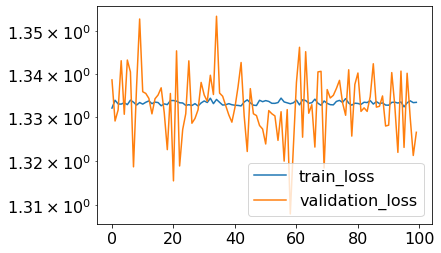

In [34]:
x = [i for i in range(len(history_train))]
fig, ax = plt.subplots()
ax.plot(x, history_train,label="train_loss")
ax.plot(x, history_val,label="validation_loss")
ax.set_yscale('log')
plt.legend()
plt.show()

In [39]:
from Util.bert_score.bert_score.score import score

def calc_bert_score(cands, refs):
    """ BERTスコアの算出

    Args:
        cands ([List[str]]): [比較元の文]
        refs ([List[str]]): [比較対象の文]

    Returns:
        [(List[float], List[float], List[float])]: [(Precision, Recall, F1スコア)]
    """
    Precision, Recall, F1 = score(cands, refs, lang="ja", verbose=True)
    return Precision.numpy().tolist(), Recall.numpy().tolist(), F1.numpy().tolist()

def FNN_bert_score(_type):
    p_history,r_history,f1_history=[],[],[]
    """ サンプル実行 """ 
    for i in range(AE_EPOCHS):
        filename=log_dir+"FNN_{}{:03}.txt".format(_type,i)
        with open(filename) as f:
            cands = ["".join(line.strip().split()[1:]) for idx, line in enumerate(f) if idx%3==0]
        with open(filename) as f:
            refs = ["".join(line.strip().split()[1:]) for idx, line in enumerate(f) if idx%3==1]
        P, R, F1 = calc_bert_score(cands, refs)
        p_history.append(sum(P)/len(P))
        r_history.append(sum(R)/len(R))
        f1_history.append(sum(F1)/len(F1))
    return p_history

fnn_bert_train=AE_bert_score("train")
fnn_bert_val=AE_bert_score("val")

calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 403.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 390.88 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 379.68 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 413.19 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.55 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 385.65 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.73 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 407.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 424.69 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 387.73 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 404.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 407.57 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 411.51 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 413.21 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 417.47 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 381.90 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.42 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 394.84 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 394.76 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.40 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 406.55 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 384.06 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 409.60 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 399.59 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 381.77 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.00 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 403.84 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 382.99 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.63 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 406.28 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 391.28 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 375.10 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.21 seconds, 347.07 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 366.57 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 406.25 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 403.68 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.03 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.17 seconds, 412.50 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.54 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.07 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 405.64 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 393.02 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 387.02 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 406.14 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 393.24 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 389.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 409.27 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 396.29 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 404.62 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 391.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.79 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 376.41 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 386.66 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 386.36 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.03 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 388.58 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 374.58 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 388.26 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 379.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 375.30 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 385.01 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 394.67 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.61 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 357.27 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.21 seconds, 349.24 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 374.60 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 374.27 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 411.16 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 389.11 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 372.54 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 408.24 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 395.97 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 385.74 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 387.34 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 364.23 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 402.67 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 367.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 380.67 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 365.70 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.21 seconds, 349.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 408.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.42 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 411.22 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 383.22 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 395.73 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 398.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 387.47 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 405.13 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.20 seconds, 361.98 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 393.20 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 397.35 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 411.24 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 405.48 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 393.26 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.21 seconds, 340.88 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 380.98 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 409.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.19 seconds, 383.08 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.18 seconds, 403.15 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 358.58 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.47 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 357.49 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.10 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 356.73 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.38 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 356.15 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.18 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.78 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.31 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.34 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.46 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.20 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.34 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 328.30 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.67 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 346.82 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.99 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.34 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.24 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 347.54 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.63 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.96 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.34 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.06 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.62 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.21 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 306.65 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 330.87 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 347.85 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.91 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.69 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.19 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.08 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.66 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.44 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.16 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 307.80 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 306.50 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.14 seconds, 294.53 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 339.99 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 344.61 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 362.83 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.47 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.36 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.65 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.04 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 347.02 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 339.85 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 359.19 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.09 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.61 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.85 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.93 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 356.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.14 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 356.42 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 306.68 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.55 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.40 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.69 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.07 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 306.17 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 319.61 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.94 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 356.77 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.47 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 357.86 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.99 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 345.16 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.11 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.92 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.28 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 346.78 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.83 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.42 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.33 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 354.45 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.51 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 350.29 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.88 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.07 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.11 seconds, 362.82 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 328.08 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.14 seconds, 295.86 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.13 seconds, 309.10 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 345.96 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 344.18 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 349.56 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 353.73 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 352.30 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 330.88 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 355.03 sentences/sec
calculating scores...
computing bert embedding.



computing greedy matching.



done in 0.12 seconds, 351.57 sentences/sec


In [40]:
from Util.selfbleu import CalcSelfBLEU
def fnn_selfbleu(_type):
    selfbleu_history=[]
    for i in range(AE_EPOCHS):
        filename=log_dir+"FNN_{}{:03}.txt".format(_type,i)
        selfbleu2=CalcSelfBLEU(filename)
        selfbleu_history.append(selfbleu2)
    return selfbleu_history
fnn_selfbleu_train=fnn_selfbleu("train")
fnn_selfbleu_val=fnn_selfbleu("val")

Self-BLEU(2-gram)：0.4481834793856796
Self-BLEU(3-gram)：0.29104962682000135
Self-BLEU(4-gram)：0.2509657674040591
Self-BLEU(2-gram)：0.4474322486453657
Self-BLEU(3-gram)：0.29554404325800854
Self-BLEU(4-gram)：0.25081815125391105
Self-BLEU(2-gram)：0.4424791534156541
Self-BLEU(3-gram)：0.2908489806975599
Self-BLEU(4-gram)：0.25239906193995126
Self-BLEU(2-gram)：0.4403862475658717
Self-BLEU(3-gram)：0.2946817747606867
Self-BLEU(4-gram)：0.2507506666475826
Self-BLEU(2-gram)：0.44212152655074743
Self-BLEU(3-gram)：0.28738882855295333
Self-BLEU(4-gram)：0.2486029440370538
Self-BLEU(2-gram)：0.44410857755529043
Self-BLEU(3-gram)：0.31120182188016676
Self-BLEU(4-gram)：0.2664320651678403
Self-BLEU(2-gram)：0.42907039492012805
Self-BLEU(3-gram)：0.27261817232378593
Self-BLEU(4-gram)：0.24561199120040778
Self-BLEU(2-gram)：0.446769789423277
Self-BLEU(3-gram)：0.2957846912624211
Self-BLEU(4-gram)：0.2547024143808596
Self-BLEU(2-gram)：0.4507083144513969
Self-BLEU(3-gram)：0.29837900816404966
Self-BLEU(4-gram)：0.2567053

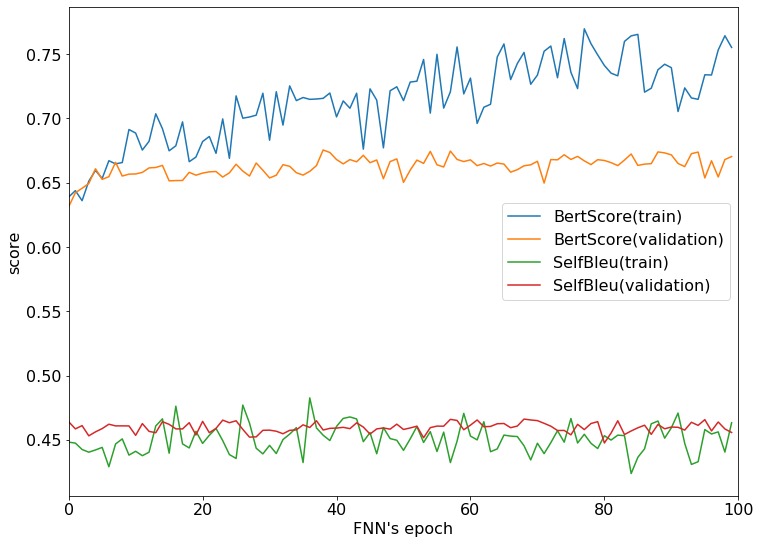

In [41]:
x = [i for i in range(len(p_history_train))]
fig = plt.figure(figsize=(12.0, 9.0))

plt.plot(x, fnn_bert_train, label="BertScore(train)")
plt.plot(x, fnn_bert_val, label="BertScore(validation)")
plt.plot(x, fnn_selfbleu_train, label="SelfBleu(train)")
plt.plot(x, fnn_selfbleu_val, label="SelfBleu(validation)")
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
plt.rcParams["font.size"] = 16

# fig, ax = plt.subplots()
plt.xlim(0, 100)
plt.xlabel("FNN's epoch")
plt.ylabel('score')
plt.legend()
plt.show()

## fasttext確認用

In [49]:
if torch.rand(1)<1/3:
    print("True")

True


In [7]:
nihongo_id=4

In [33]:
nihongo_id+=1
norm_list=[]
word=TEXT.vocab.itos[nihongo_id]
nihongo_vector=share_conv.weight[nihongo_id]
for i, val in enumerate(share_conv.weight):
    cos=torch.nn.CosineSimilarity(dim=0)
    diff=cos(nihongo_vector,val)
    norm=torch.norm(diff)
    norm_list.append((norm,i))
norm_list.sort(reverse=True)
print("「"+word+"」の似ている単語")
for i in range(1,11):
    val=norm_list[i][0]
    id_=norm_list[i][1]
    print(TEXT.vocab.itos[id_]+":"+str(val))

「その」の似ている単語
この:tensor(0.7487, device='cuda:0', grad_fn=<NormBackward0>)
の:tensor(0.6892, device='cuda:0', grad_fn=<NormBackward0>)
が:tensor(0.6426, device='cuda:0', grad_fn=<NormBackward0>)
た:tensor(0.6121, device='cuda:0', grad_fn=<NormBackward0>)
それ:tensor(0.6105, device='cuda:0', grad_fn=<NormBackward0>)
これ:tensor(0.6037, device='cuda:0', grad_fn=<NormBackward0>)
も:tensor(0.5796, device='cuda:0', grad_fn=<NormBackward0>)
を:tensor(0.5789, device='cuda:0', grad_fn=<NormBackward0>)
しかし:tensor(0.5774, device='cuda:0', grad_fn=<NormBackward0>)
に:tensor(0.5679, device='cuda:0', grad_fn=<NormBackward0>)


In [82]:
with open("./data/foruse/"+"_".join(["train",data_source,feature])+'.tsv') as f:
    c=0
    for i in f:
        c+=1
print(c)

86188
